In [1]:
import configparser
import sys
import warnings

import plotly.graph_objects as go
import torch

# Load configuration
config = configparser.ConfigParser()
config_path = "./../config.ini"
config.read(config_path)
PROJECT_DIR = config["paths"]["project_dir"]
LOG_DIR = config["paths"]["logs_dir"]
sys.path.append(PROJECT_DIR)

In [3]:
from src.test_functions import sinusoidal_synthetic

test_function = sinusoidal_synthetic
# Generate input-output pairs from the test function
n_train = 30
train_X = torch.linspace(-1, 1, n_train).view(-1, 1)
train_Y = test_function(train_X) + torch.randn(train_X.size()) * 0.5  # Add noise
train_X.shape, train_Y.shape

# Generate test input
n_test = 500
test_X = torch.linspace(-1, 1, n_test).view(-1, 1)
true_Y = test_function(test_X)


# Plot the true test function using Plotly
fig = go.Figure()

# True function plot
fig.add_trace(go.Scatter(x=test_X.numpy().flatten(), y=true_Y.numpy().flatten(), mode='lines', name='True Function'))
fig.add_trace(go.Scatter(x=train_X.numpy().flatten(), y=train_Y.numpy().flatten(), mode='markers', name='Train Data'))
# Layout settings
fig.update_layout(title="Test Function: Sinusoidal Synthetic",
                  xaxis_title="x",
                  yaxis_title="y",
                  showlegend=True)

# Show the plot
fig.show()

In [4]:
import torch
from tptorch.mlls.exact_student_t_marginal_log_likelihood import ExactStudentTMarginalLogLikelihood
from botorch.fit import fit_gpytorch_mll
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.priors import GammaPrior

from src.models import SingleTaskTP


# Define the Matern Kernel with nu=2.5 and ARD enabled
ard_num_dims = train_X.shape[-1]  # Input dimension for ARD
matern_kernel = MaternKernel(
    nu=2.5, ard_num_dims=ard_num_dims, lengthscale_prior=GammaPrior(3.0, 6.0)
)

# ScaleKernel allows for automatic scaling of the output
kernel = ScaleKernel(matern_kernel, outputscale_prior=GammaPrior(2.0, 0.15))

# Define the Student-t Process (TP) model using the specified kernel
model = SingleTaskTP(train_X, train_Y, covar_module=kernel)
mll = ExactStudentTMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_mll(mll)

/var/folders/_b/b62kq0490fn2ptq7m4mbp8yr0000gp/T/ipykernel_41444/1886432388.py:20: InputDataWarning:

The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444

/Users/keisukeonoue/ws/robust_BO/rbo-env/lib/python3.12/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning:

Input data is not contained to the unit cube. Please consider min-max scaling the input data.



RuntimeError: Likelihoods expects a MultivariateNormal or Normal input to make marginal predictions, or a torch.Tensor for conditional predictions. Got a MultivariateStudentT

In [7]:
mll.named_priors

<bound method Module.named_priors of ExactStudentTMarginalLogLikelihood(
  (likelihood): StudentTLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskTP(
    (likelihood): StudentTLikelihood(
      (noise_covar): HomoskedasticNoise(
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): MaternKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
      )
      (outputscale_prior): GammaPrior()
      (raw_outputscale_constraint): Positive()
    )
    (outcome_transform): Standardize()
  )
)>

In [11]:
for param_name, param in model.named_parameters():
    print(f"Parameter name: {param_name}")
    print(param)
    print("")

Parameter name: nu
Parameter containing:
tensor(5., requires_grad=True)

Parameter name: likelihood.noise_covar.raw_noise
Parameter containing:
tensor([0.], requires_grad=True)

Parameter name: mean_module.raw_constant
Parameter containing:
tensor(0., requires_grad=True)

Parameter name: covar_module.raw_outputscale
Parameter containing:
tensor(0., requires_grad=True)

Parameter name: covar_module.base_kernel.raw_lengthscale
Parameter containing:
tensor([[0.]], requires_grad=True)



In [32]:
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.priors import GammaPrior

# Define the Matern Kernel with nu=2.5 and ARD enabled
ard_num_dims = train_X.shape[-1]  # Input dimension for ARD
matern_kernel = MaternKernel(
    nu=2.5, ard_num_dims=ard_num_dims, lengthscale_prior=GammaPrior(3.0, 6.0)
)

# ScaleKernel allows for automatic scaling of the output
kernel = ScaleKernel(matern_kernel, outputscale_prior=GammaPrior(2.0, 0.15))

# Define the Gaussian Process (GP) model using the specified kernel
gp_model = SingleTaskGP(train_X, train_Y, covar_module=kernel)

# Define the Marginal Log Likelihood (MLL) for the GP model
mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)

# # Train the GP model
# fit_gpytorch_mll(mll)

# # Use the trained GP model to make predictions on the test data
# gp_model.eval()
# with torch.no_grad():
#     posterior = gp_model.posterior(test_X)
#     pred_mean = posterior.mean
#     pred_variance = posterior.variance
#     pred_stddev = pred_variance.sqrt()

# # Plot the true function, training data, and predicted mean with uncertainty
# fig = go.Figure()

# # Plot true function
# fig.add_trace(go.Scatter(
#     x=test_X.numpy().flatten(),
#     y=true_Y.numpy().flatten(),
#     mode='lines',
#     name='True Function'
# ))

# # Plot training data
# fig.add_trace(go.Scatter(
#     x=train_X.numpy().flatten(),
#     y=train_Y.numpy().flatten(),
#     mode='markers',
#     name='Train Data'
# ))

# # Plot predicted mean
# fig.add_trace(go.Scatter(
#     x=test_X.numpy().flatten(),
#     y=pred_mean.numpy().flatten(),
#     mode='lines',
#     name='GP Mean Prediction'
# ))

# # Plot uncertainty (mean +/- 2 * stddev for 95% confidence interval)
# fig.add_trace(go.Scatter(
#     x=test_X.numpy().flatten(),
#     y=(pred_mean - 2 * pred_stddev).numpy().flatten(),
#     fill=None,
#     mode='lines',
#     line=dict(color='lightgrey'),
#     showlegend=False
# ))

# fig.add_trace(go.Scatter(
#     x=test_X.numpy().flatten(),
#     y=(pred_mean + 2 * pred_stddev).numpy().flatten(),
#     fill='tonexty',  # Fill the area between the two traces
#     mode='lines',
#     line=dict(color='lightgrey'),
#     name='Uncertainty (95% CI)'
# ))

# # Layout settings
# fig.update_layout(
#     title="GP Regression with Matern Kernel (nu=2.5)",
#     xaxis_title="x",
#     yaxis_title="y",
#     showlegend=True
# )

# # Show the plot
# fig.show()


/var/folders/_b/b62kq0490fn2ptq7m4mbp8yr0000gp/T/ipykernel_41444/4242987247.py:18: InputDataWarning:

The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444

/Users/keisukeonoue/ws/robust_BO/rbo-env/lib/python3.12/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning:

Input data is not contained to the unit cube. Please consider min-max scaling the input data.

/Users/keisukeonoue/ws/robust_BO/rbo-env/lib/python3.12/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning:

Data is not standardized (std = tensor([1.6313]), mean = tensor([0.3910])). Please consider scaling the input to zero mean and unit variance.



In [33]:
mll

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): MaternKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
      )
      (outputscale_prior): GammaPrior()
      (raw_outputscale_constraint): Positive()
    )
  )
)

In [34]:
import torch
import gpytorch

# Assuming 'mll' is your ExactMarginalLogLikelihood instance
model = mll.model

def get_model_parameters_with_info(model):
    model_info = {}
    # Iterate over all modules and parameters
    for name, param in model.named_parameters():
        # Initialize a dictionary to store parameter info
        param_info = {
            'value': param.detach().cpu().numpy(),
            'prior': None,
            'constraint': None
        }
        # Split the parameter name to get the module path and parameter name
        module_path = name.split('.')[:-1]
        param_name = name.split('.')[-1]
        # Navigate to the module containing the parameter
        module = model
        for attr in module_path:
            module = getattr(module, attr)
        # Check for prior
        if param_name in module._priors:
            prior = module._priors[param_name]
            # Extract prior parameters (e.g., concentration and rate for GammaPrior)
            if isinstance(prior, gpytorch.priors.GammaPrior):
                prior_info = {
                    'name': 'GammaPrior',
                    'concentration': prior.concentration.item(),
                    'rate': prior.rate.item(),
                }
            else:
                prior_info = {
                    'name': type(prior).__name__,
                    'parameters': prior.__dict__,
                }
            param_info['prior'] = prior_info
        # Check for constraint
        if param_name in module._constraints:
            constraint = module._constraints[param_name]
            constraint_info = {
                'name': type(constraint).__name__,
                'parameters': constraint.__dict__,
            }
            param_info['constraint'] = constraint_info
        # Add the parameter info to the dictionary
        model_info[name] = param_info
    return model_info

# Retrieve the parameters with their info
parameters_info = get_model_parameters_with_info(gp_model)

# Now 'parameters_info' is a dictionary containing all parameters and their details
# You can print or inspect it as needed
import pprint
pprint.pprint(parameters_info)


{'covar_module.base_kernel.raw_lengthscale': {'constraint': None,
                                              'prior': None,
                                              'value': array([[0.]], dtype=float32)},
 'covar_module.raw_outputscale': {'constraint': None,
                                  'prior': None,
                                  'value': array(0., dtype=float32)},
 'likelihood.noise_covar.raw_noise': {'constraint': None,
                                      'prior': None,
                                      'value': array([2.0000005], dtype=float32)},
 'mean_module.raw_constant': {'constraint': None,
                              'prior': None,
                              'value': array(0., dtype=float32)}}


Iter 1/50 - Loss: 1.436752438545227
Iter 2/50 - Loss: 1.3996044397354126
Iter 3/50 - Loss: 1.362102746963501
Iter 4/50 - Loss: 1.3240209817886353
Iter 5/50 - Loss: 1.2853364944458008
Iter 6/50 - Loss: 1.246122121810913
Iter 7/50 - Loss: 1.2070362567901611
Iter 8/50 - Loss: 1.1692688465118408
Iter 9/50 - Loss: 1.1340703964233398
Iter 10/50 - Loss: 1.1022404432296753
Iter 11/50 - Loss: 1.0737756490707397
Iter 12/50 - Loss: 1.0477889776229858
Iter 13/50 - Loss: 1.022788405418396
Iter 14/50 - Loss: 0.9972414970397949
Iter 15/50 - Loss: 0.9700948596000671
Iter 16/50 - Loss: 0.9409821629524231
Iter 17/50 - Loss: 0.910124659538269
Iter 18/50 - Loss: 0.878115177154541
Iter 19/50 - Loss: 0.8457368612289429
Iter 20/50 - Loss: 0.8138594627380371
Iter 21/50 - Loss: 0.7833458781242371
Iter 22/50 - Loss: 0.7549072504043579
Iter 23/50 - Loss: 0.7288991808891296
Iter 24/50 - Loss: 0.70514315366745
Iter 25/50 - Loss: 0.6829236149787903
Iter 26/50 - Loss: 0.6612869501113892
Iter 27/50 - Loss: 0.63956153

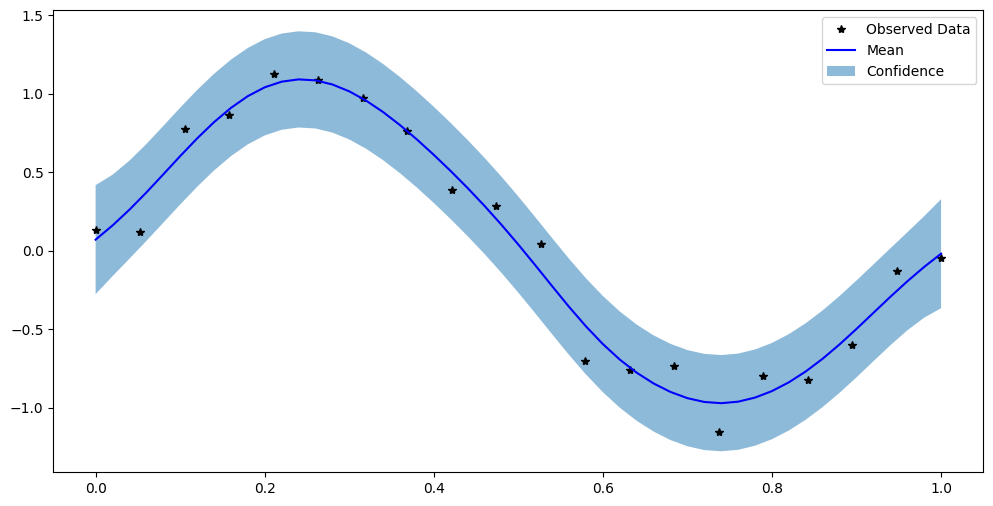

In [36]:
# Import necessary libraries
import torch
import gpytorch
from gpytorch.models import ExactGP
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, MaternKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.priors import GammaPrior
from gpytorch.constraints import GreaterThan, Positive

# Generate synthetic training data (replace with your own data)
train_X = torch.linspace(0, 1, 20)
train_Y = torch.sin(train_X * (2 * torch.pi)) + torch.randn(train_X.size()) * 0.2

# Ensure train_X and train_Y have correct shapes
train_X = train_X.unsqueeze(-1)  # Shape: [n_samples, n_features]
train_Y = train_Y  # Shape: [n_samples]

# Define the custom Exact GP model
class CustomExactGPModel(ExactGP):
    def __init__(self, train_X, train_Y, likelihood):
        super(CustomExactGPModel, self).__init__(train_X, train_Y, likelihood)
        
        # Mean function
        self.mean_module = ConstantMean()
        
        # Covariance function (kernel)
        # Define the lengthscale prior and constraint
        lengthscale_prior = GammaPrior(concentration=3.0, rate=6.0)
        lengthscale_constraint = Positive()
        
        base_kernel = MaternKernel(
            nu=2.5,  # Matern 5/2 kernel
            lengthscale_prior=lengthscale_prior,
            lengthscale_constraint=lengthscale_constraint,
        )
        
        # Define the outputscale prior and constraint
        outputscale_prior = GammaPrior(concentration=2.0, rate=0.15)
        outputscale_constraint = Positive()
        
        self.covar_module = ScaleKernel(
            base_kernel=base_kernel,
            outputscale_prior=outputscale_prior,
            outputscale_constraint=outputscale_constraint,
        )
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Define the noise prior and constraint
noise_prior = GammaPrior(concentration=1.1, rate=0.05)
noise_constraint = GreaterThan(1e-4)

# Initialize the likelihood
likelihood = GaussianLikelihood(
    noise_prior=noise_prior,
    noise_constraint=noise_constraint,
)

# Instantiate the model
model = CustomExactGPModel(train_X, train_Y, likelihood)

# Set model and likelihood in training mode
model.train()
likelihood.train()

# Define the optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()}
], lr=0.1)

# Define the loss function (marginal log likelihood)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# Training loop
training_iterations = 50

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(train_X)
    loss = -mll(output, train_Y)
    
    # Ensure loss is scalar
    loss_value = loss.item()
    print(f'Iter {i + 1}/{training_iterations} - Loss: {loss_value}')
    
    loss.backward()
    optimizer.step()

# Set model and likelihood to evaluation mode
model.eval()
likelihood.eval()

# Test points
test_X = torch.linspace(0, 1, 51).unsqueeze(-1)

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_X))

# (Optional) Plotting the results
import matplotlib.pyplot as plt

# Convert to numpy for plotting
train_X_np = train_X.squeeze().numpy()
train_Y_np = train_Y.numpy()
test_X_np = test_X.squeeze().numpy()
observed_mean = observed_pred.mean.numpy()
lower, upper = observed_pred.confidence_region()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train_X_np, train_Y_np, 'k*')
plt.plot(test_X_np, observed_mean, 'b')
plt.fill_between(test_X_np, lower.numpy(), upper.numpy(), alpha=0.5)
plt.legend(['Observed Data', 'Mean', 'Confidence'])
plt.show()
